### Data Preparation

**Import Library**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
sns.set_theme(style="whitegrid")
import matplotlib.dates as mdates

# !pip install keras-tuner
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import random

**Read the files**

In [5]:
set1 = pd.read_csv('../Data/SET_main.csv')

# This file is consist of data that have Nan values
set2 = pd.read_csv('../Data/SET_residual.csv')

sp500 = pd.read_csv('../Data/sp500_main.csv')

In [6]:
set1 = set1.set_index('Date')
set1

,ADVANC.BK,AOT.BK,BBL.BK,BDMS.BK,BH.BK,CPALL.BK,CPF.BK,CPN.BK,DELTA.BK,HMPRO.BK,INTUCH.BK,IVL.BK,KBANK.BK,KTB.BK,MINT.BK,PTT.BK,PTTEP.BK,SCC.BK,TRUE.BK,TTB.BK
Date,,,,,,,,,,,,,,,,,,,,
2014-01-02,115.707695,13.004045,112.167664,8.865041,68.680244,33.136929,22.704105,31.580967,4.015339,4.772995,36.063667,14.913610,107.741776,9.801532,15.467829,16.889353,93.353264,263.643036,5.398062,1.198794
2014-01-03,121.276527,12.870900,113.856918,8.824374,69.914032,33.136929,22.704105,31.159885,3.846470,4.633434,36.908916,14.837523,111.814484,9.864767,15.223605,16.519508,92.148727,262.951050,5.318678,1.186436
2014-01-06,124.370323,12.648986,117.235466,9.678345,69.091530,33.344040,21.773605,31.580967,3.696364,4.605521,37.190655,14.913610,116.257446,9.991237,16.363337,16.272951,89.137291,266.411011,5.477446,1.217332
2014-01-07,129.939133,13.447869,120.276161,9.556350,68.474625,33.965351,22.704105,32.844200,3.771417,4.717172,38.176777,15.446239,119.959915,10.244180,17.096024,17.320827,92.449844,269.178833,5.636212,1.229691
2014-01-08,127.464096,12.870900,119.938301,9.312360,67.446480,33.551147,22.145803,32.633663,3.790180,4.633434,38.035904,15.978869,119.959915,9.991237,16.526155,17.567392,94.256668,271.254791,5.398062,1.248229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,296.000000,61.209999,150.500000,26.000000,212.000000,63.750000,24.200001,60.500000,151.000000,9.900000,102.500000,24.600000,153.500000,20.299999,27.750000,32.250000,128.500000,184.000000,11.900000,1.790000
2024-12-04,289.000000,61.500000,151.500000,25.750000,211.000000,64.000000,24.100000,60.500000,151.000000,9.700000,100.000000,24.500000,155.000000,20.600000,28.000000,32.250000,128.000000,183.000000,12.100000,1.780000
2024-12-06,295.000000,61.000000,152.000000,25.500000,210.000000,63.000000,24.100000,60.250000,150.500000,9.700000,102.500000,25.250000,156.000000,20.700001,27.500000,32.250000,128.000000,183.500000,11.800000,1.830000


In [7]:
set1.shape

(2662, 20)

### Modeling 

**Data Preparation**

*Creating the function*

In [25]:
# Creating a function for data preparation 
def data_prep(df, stock_columns, test_size, window_size):
    results = {}
    
    for stock in stock_columns:
        print(f"Stock: {stock}")

        df.index = pd.to_datetime(df.index)
        
        # Plot training and test sets
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], df[stock][:-test_size], color='black', label="Training set")
        plt.plot(df.index[-test_size:], df[stock][-test_size:], color='blue', label="Test set")
        plt.title(f"{stock} Training and Test Sets", fontsize=15)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        
        # show only year
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())   
        plt.xlim(df.index.min(), df.index.max())
        plt.grid(color="lightgray")  
        plt.gca().set_facecolor("white") 
        plt.legend(loc="upper left")
        plt.tight_layout() 
        plt.show()

        # Scale the data 
        scaler = MinMaxScaler()
        
        # Window size (e.g., 30 days)
        window_size = window_size

        # Training set
        train_data = df[stock][:-test_size].values
        train_data = scaler.fit_transform(train_data.reshape(-1, 1))
        
        X_train, y_train = [], []
        for i in range(window_size, len(train_data)):
            X_train.append(train_data[i-window_size:i, 0])
            y_train.append(train_data[i, 0])
        
        # Testing set
        test_data = df[stock][-test_size-window_size:].values
        test_data = scaler.transform(test_data.reshape(-1, 1))
        
        X_test, y_test = [], []
        for i in range(window_size, len(test_data)):
            X_test.append(test_data[i-window_size:i, 0])
            y_test.append(test_data[i, 0])
        
        # Convert to numpy arrays to make it acceptable for the model
        X_train = np.array(X_train).reshape(-1, window_size, 1)
        X_test = np.array(X_test).reshape(-1, window_size, 1)
        y_train = np.array(y_train).reshape(-1, 1)
        y_test = np.array(y_test).reshape(-1, 1)

        print(f'{stock} - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}')
        print(f'{stock} - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}')
        
        # Store results
        results[stock] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test}
    
    return results


*Applying the function for SET1 (Stock exchange of Thailand)*

In [28]:
stock_columns = list(set1.columns)
test_size = 360 
window_size = 60

Stock: ADVANC.BK


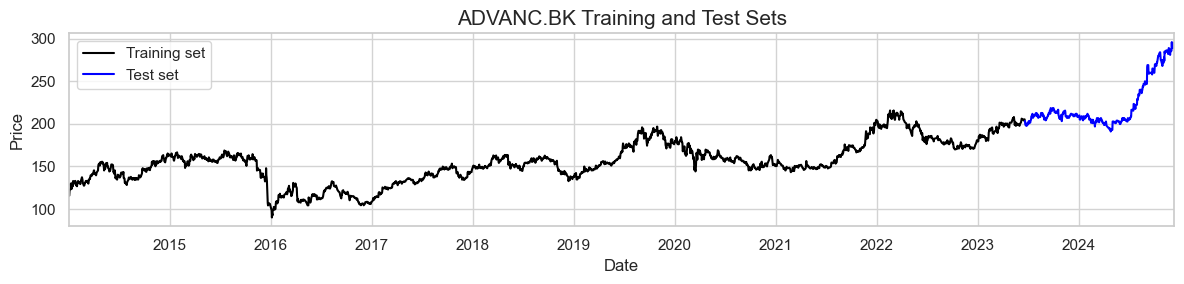

ADVANC.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
ADVANC.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: AOT.BK


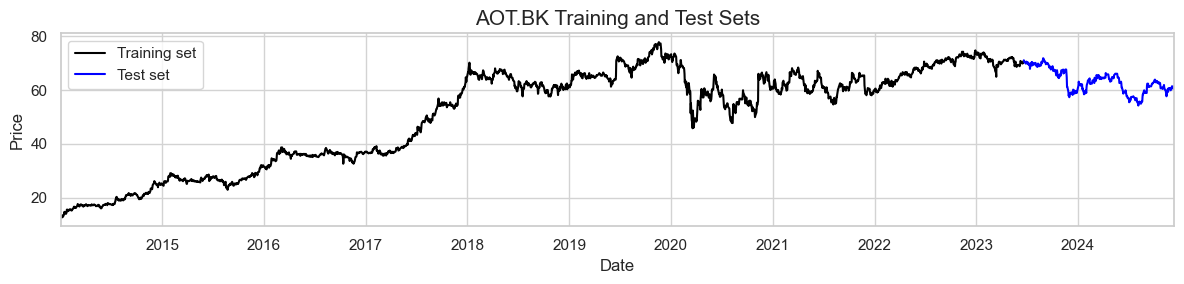

AOT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
AOT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BBL.BK


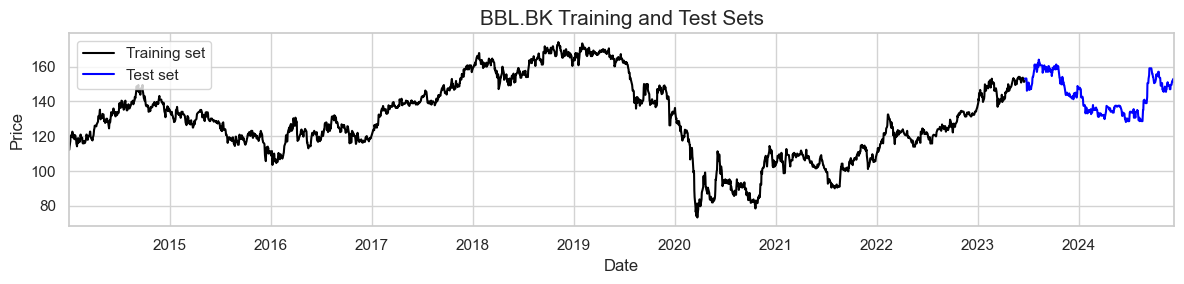

BBL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BBL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BDMS.BK


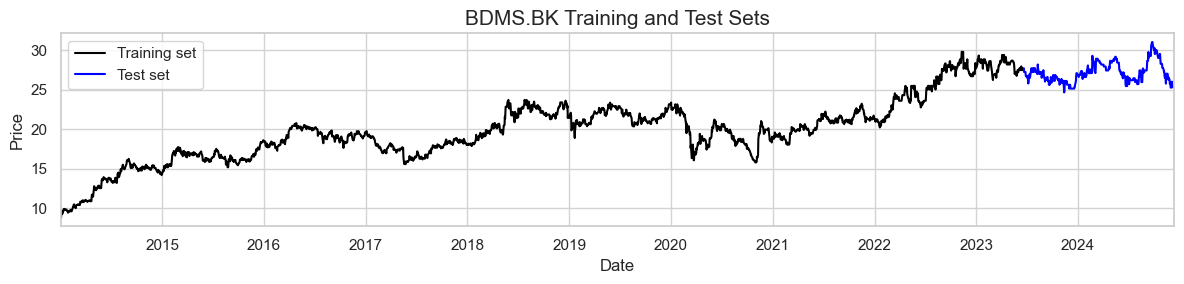

BDMS.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BDMS.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BH.BK


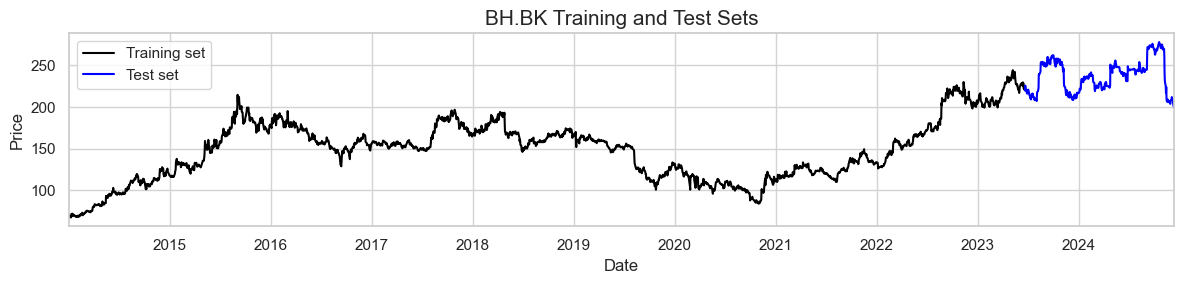

BH.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BH.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPALL.BK


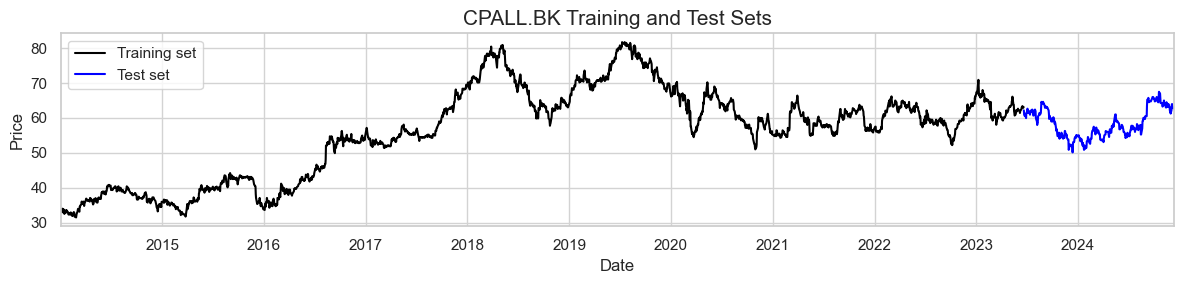

CPALL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPALL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPF.BK


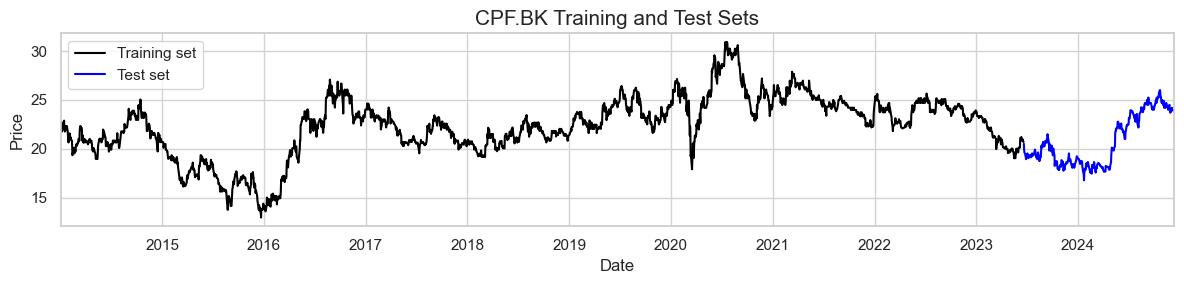

CPF.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPF.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPN.BK


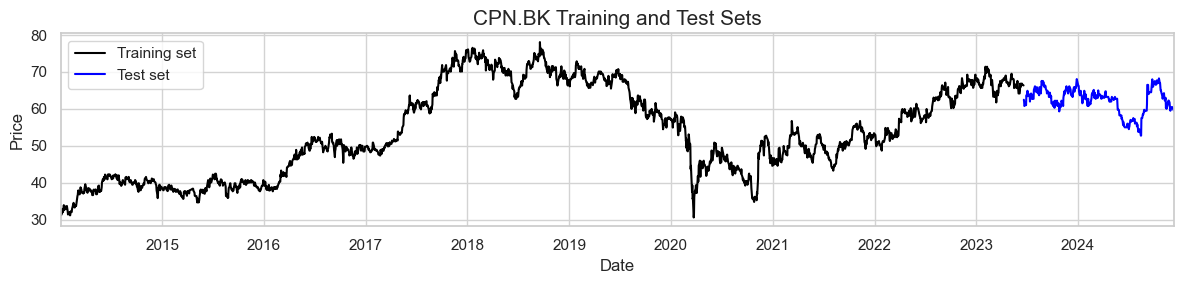

CPN.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPN.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: DELTA.BK


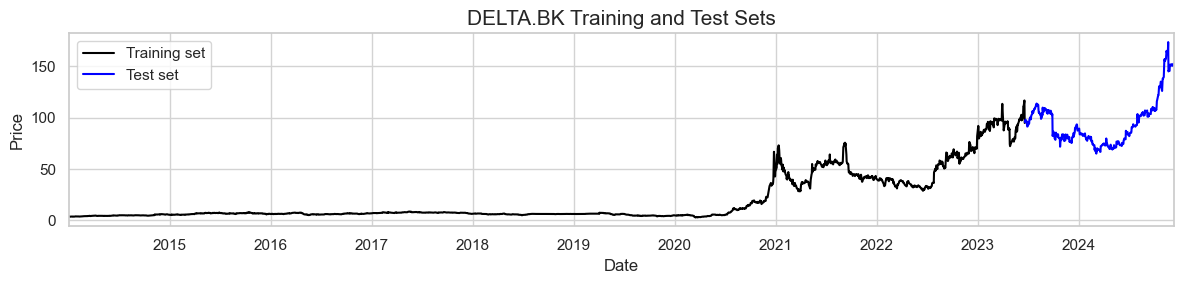

DELTA.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
DELTA.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: HMPRO.BK


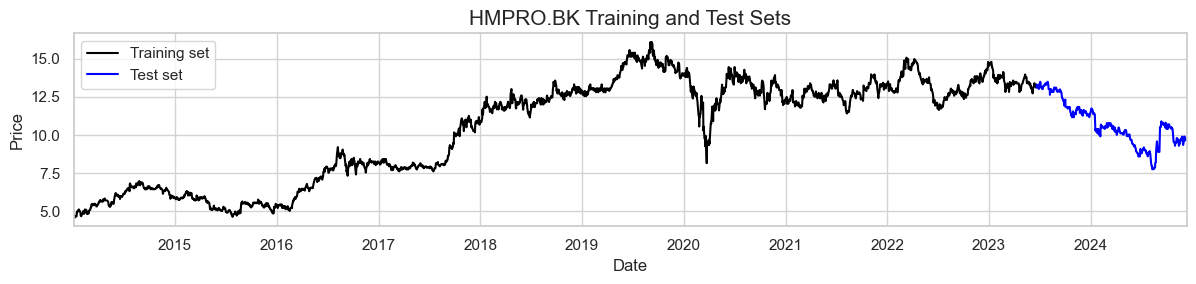

HMPRO.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
HMPRO.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: INTUCH.BK


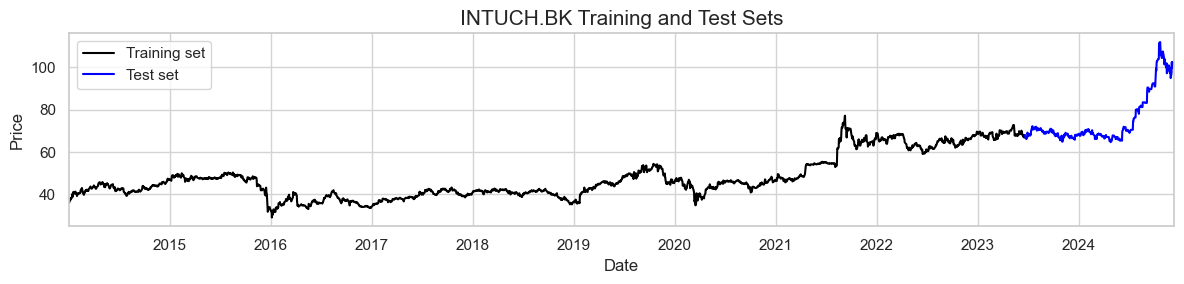

INTUCH.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
INTUCH.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: IVL.BK


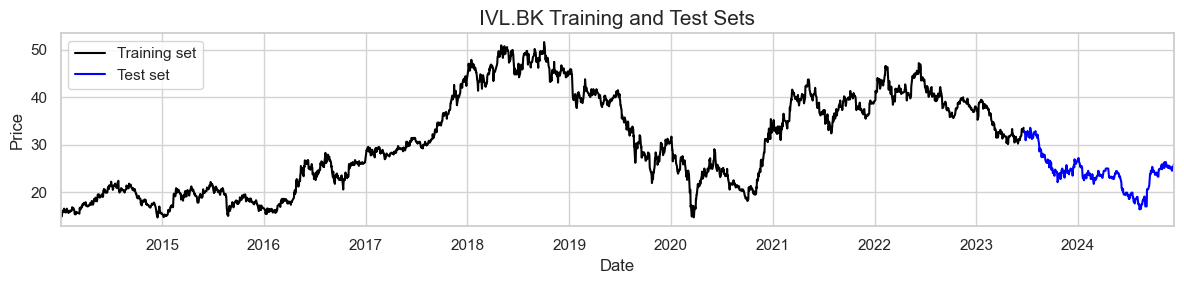

IVL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
IVL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: KBANK.BK


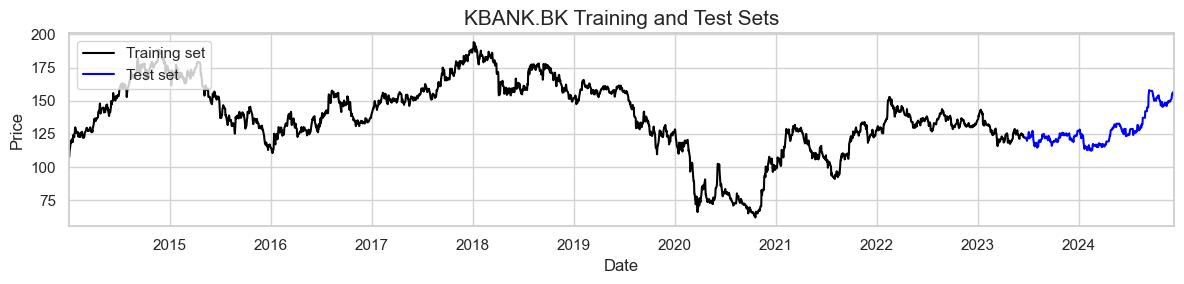

KBANK.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
KBANK.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: KTB.BK


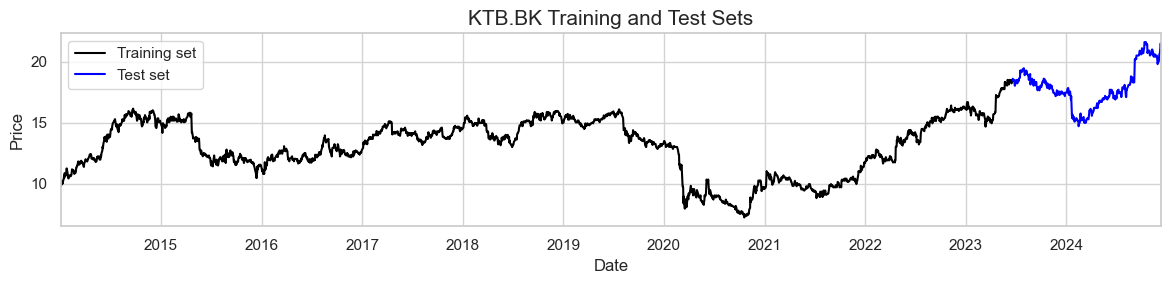

KTB.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
KTB.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: MINT.BK


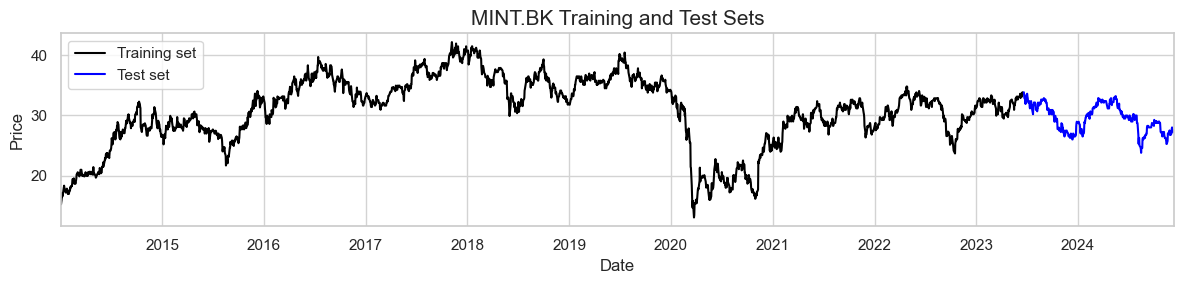

MINT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
MINT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PTT.BK


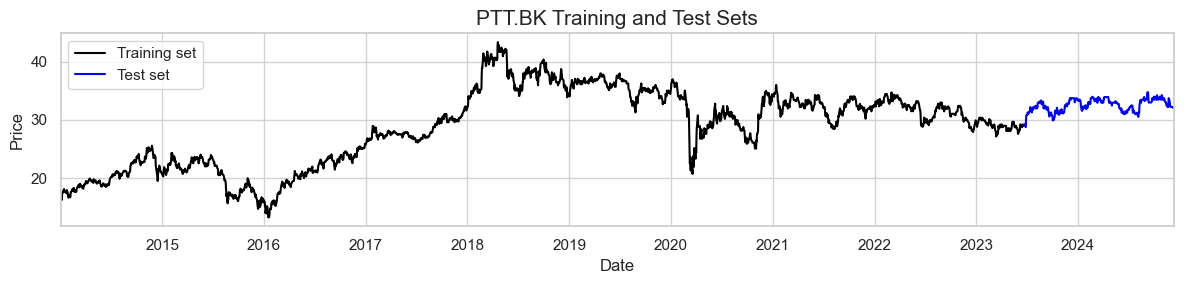

PTT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
PTT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PTTEP.BK


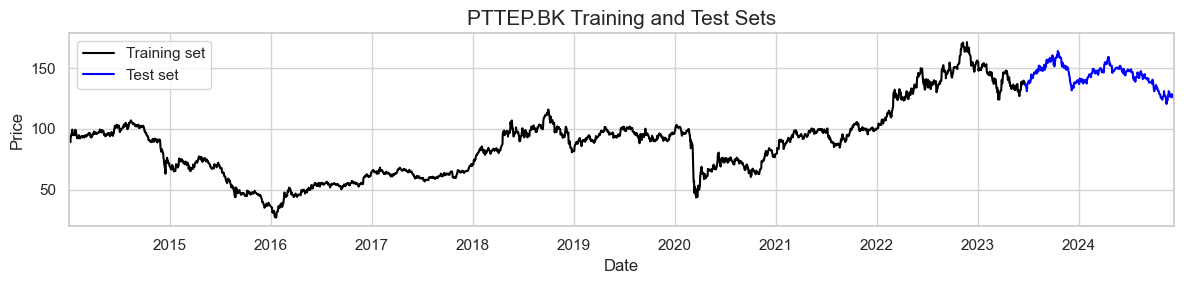

PTTEP.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
PTTEP.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: SCC.BK


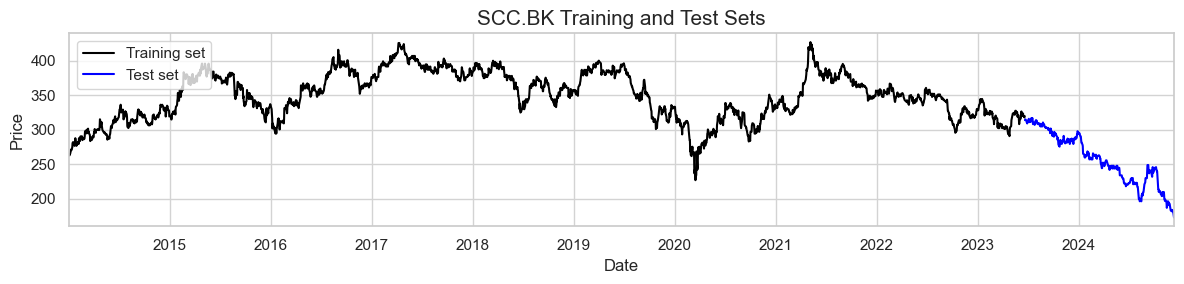

SCC.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
SCC.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TRUE.BK


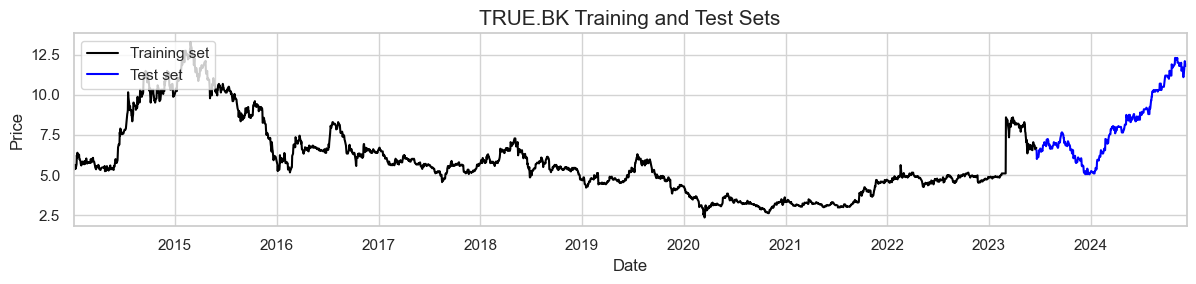

TRUE.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
TRUE.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TTB.BK


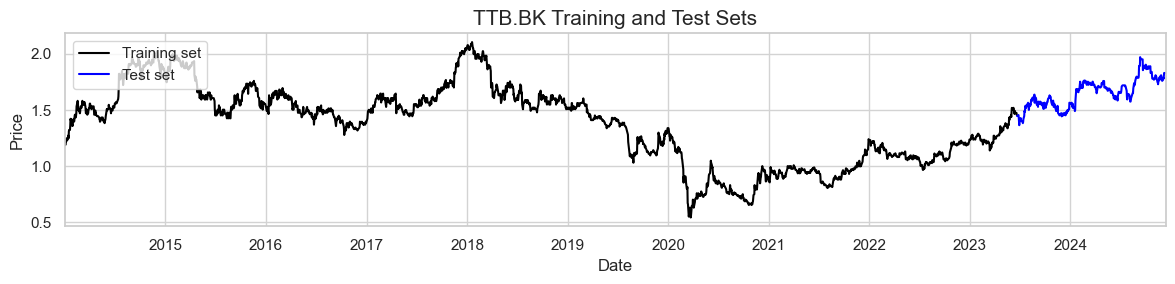

TTB.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
TTB.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)


In [30]:
# data preparation for dataframe set1
# Adjusting the portfolio for 1 year time frame 
results = data_prep(df=set1, stock_columns=stock_columns, test_size=test_size, window_size=window_size)

**Create function for LSTM model and Training**

*Create the model*

In [34]:
# Set random seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

def define_model(units_lstm_1, units_lstm_2, units_lstm_3, dropout_1, dropout_2, dropout_3, dense_units, optimizer_name):
    input1 = Input(shape=(window_size, 1))
    
    # First LSTM layer 
    x = LSTM(units=units_lstm_1, return_sequences=True)(input1)  
    x = Dropout(dropout_1)(x)
    
    # Second LSTM layer
    x = LSTM(units=units_lstm_2, return_sequences=True)(x)
    x = Dropout(dropout_2)(x)
    
    # Third LSTM layer
    x = LSTM(units=units_lstm_3)(x)
    x = Dropout(dropout_3)(x)
    
    # Dense layer with dynamic units
    x = Dense(dense_units, activation='relu')(x)
    
    # Output layer
    dnn_output = Dense(1)(x)

    # Map optimizer name to optimizer object
    optimizer_mapping = {
        'adam': Adam(),
        'nadam': Nadam(),
        'rmsprop': RMSprop()
    }
    optimizer = optimizer_mapping.get(optimizer_name, Adam())
    
    # Compile the model
    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.summary()
    
    return model

**Find the best hyperparameters**

In [37]:
# Function to Find the best hyperparameters
input1 = Input(shape=(window_size , 1))
def build_model(hp):
    # Tune the number of units in LSTM layers
    x = LSTM(units=hp.Int('units_layer_1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout_layer_3', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])

    # Tune the optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return model


In [39]:
# Loop through each column 
for stock in set1.columns:
    # Recall X_train, X_test, y_train, y_test for each stock
    X_train = results[stock]['X_train']
    X_test = results[stock]['X_test']
    y_train = results[stock]['y_train']
    y_test = results[stock]['y_test']
    
    # Now you can use these variables (X_train, X_test, y_train, y_test) for further processing
    print(f"Processed {stock}: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Processed ADVANC.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed AOT.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BBL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BDMS.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BH.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPALL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPF.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPN.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed DELTA.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed HMPRO.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed INTUCH.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed IVL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed KBANK.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed K

In [41]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error', 
    max_trials=2,  
    executions_per_trial=1,  
    directory='tuner_results',
    project_name='lstm_tuning', 
    overwrite=True)
    

**Loop for all stocks name finding best hyperparameters, fit, and evaluate the model**

In [52]:
import time 
def find_fit_eva(df, test_size, results, tuner, define_model):
    # Start the timer for the entire process
    t0 = time.time()
    
    # Initialize dictionary to store hyperparameters + predictions 
    hyperparameters_ = {}
    predictions_ = {}
    
    # Loop through each stock column in the dataframe
    for stock in df.columns:
        # Recall X_train, X_test, y_train, y_test for each stock
        X_train = results[stock]['X_train']
        X_test = results[stock]['X_test']
        y_train = results[stock]['y_train']
        y_test = results[stock]['y_test']
        
        # Hyperparameter tuning search for the current stock
        print(f"Starting tuning for {stock}...")
        tuner.search(X_train, y_train, 
                     epochs=50, 
                     batch_size=32, 
                     validation_split=0.2, 
                     verbose=1)
        
        # Get the best hyperparameters
        best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
        print(f"Best Hyperparameters for {stock}:\n {best_hyperparameters.values}")
    
        # Extract parameters values
        units_lstm_1 = best_hyperparameters['units_layer_1']
        units_lstm_2 = best_hyperparameters['units_layer_2']
        units_lstm_3 = best_hyperparameters['units_layer_3']
        dropout_1 = best_hyperparameters['dropout_layer_1']
        dropout_2 = best_hyperparameters['dropout_layer_2']
        dropout_3 = best_hyperparameters['dropout_layer_3']
        dense_units = best_hyperparameters['dense_units']
        optimizer_name = best_hyperparameters['optimizer']
    
        # Save the hyperparameters in a dictionary of DataFrames
        hyperparameters_dict = best_hyperparameters.values
        hyperparameters_[stock] = pd.DataFrame([hyperparameters_dict])
        print(hyperparameters_[stock].T) 
        
        # Define the model with the best hyperparameters
        model = define_model(units_lstm_1, units_lstm_2, units_lstm_3, dropout_1, dropout_2, dropout_3, dense_units, optimizer_name)
        
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
        
        # Evaluate the model
        print(f"\nEvaluating best model for {stock}")
        test_loss = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test) 
        print(f'Test loss for {stock}: {test_loss:.4f}')
    
        # Inverse transform predictions and true values
        scaler = MinMaxScaler()
        train_data = df[stock][:-test_size].values
        scaler.fit(train_data.reshape(-1, 1))  # Fit scaler only on training data
        y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_test_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        train_data = scaler.transform(train_data.reshape(-1, 1))

        # Store the predicted values for the stock
        predictions_[stock] = y_test_pred
        
        # Calculate evaluation metrics
        MSE = mean_squared_error(y_test_true, y_test_pred)
        RMSE = np.sqrt(MSE)
        print(f"Test MSE for {stock}: {MSE:.4f}")
        print(f"Test RMSE for {stock}: {RMSE:.4f}")

        df.index = pd.to_datetime(df.index)
        
        # Plot the prices predicted with actual
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], scaler.inverse_transform(train_data), color='black', label='Training Data')
        plt.plot(df.index[-test_size:], y_test_true, color='blue', label='Actual Test Data')
        plt.plot(df.index[-test_size:], y_test_pred, color='red', label='Predicted Test Data')
        plt.title(f'Model Performance on {stock} Prediction', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend(loc='upper left')
        plt.show()

        # Save the images
        plt.savefig(f'../images/{stock}_prediction_chart.png', format='png')
        
    # Time to run in seconds for the entire process
    print(f"Total time taken for the entire process: {time.time() - t0} seconds")
    
    return hyperparameters_ , predictions_


Starting tuning for ADVANC.BK...
Best Hyperparameters for ADVANC.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0398 - val_loss: 0.0029
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0103 - val_loss: 0.0030
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0084 - val_loss: 0.0295
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0061 - val_loss: 0.0162
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0067 - val_loss: 0.0313
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0

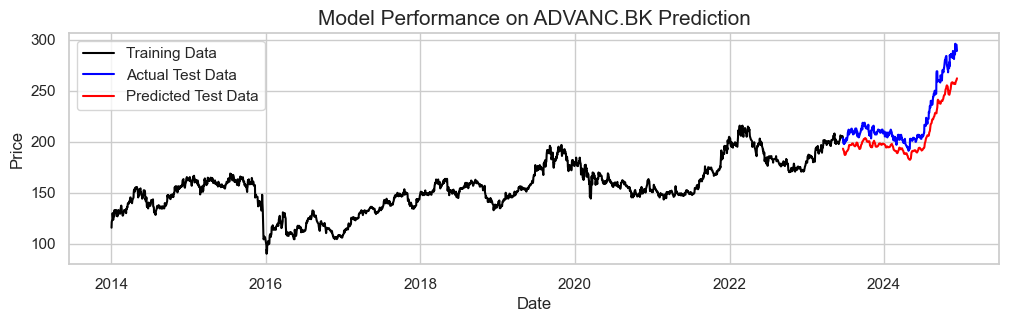

Starting tuning for AOT.BK...
Best Hyperparameters for AOT.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0776 - val_loss: 0.0703
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0184 - val_loss: 0.0817
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0137 - val_loss: 0.0988
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0097 - val_loss: 8.6633e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0058 - val_loss: 0.0320
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0066 - val_loss: 0.0196
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0056 - val_loss: 0.0445
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0062 - val_loss: 9.6497e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0038 - val_loss: 0.0684
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0058 - val_loss: 0.0276
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step -

<Figure size 640x480 with 0 Axes>

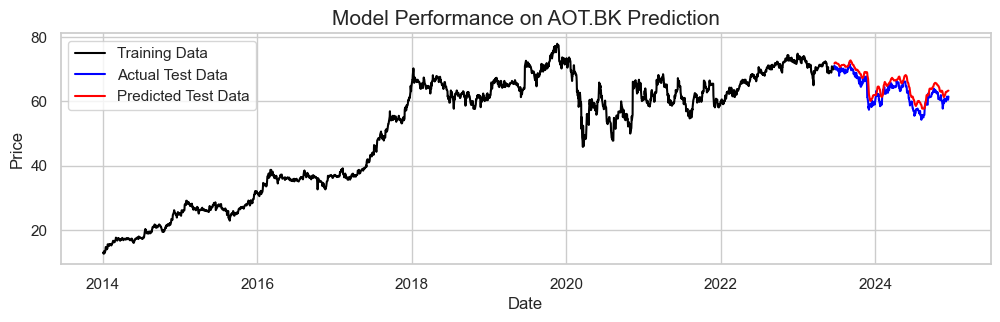

Starting tuning for BBL.BK...
Best Hyperparameters for BBL.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.1090 - val_loss: 0.0112
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0197 - val_loss: 0.0043
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0125 - val_loss: 0.0364
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0116 - val_loss: 0.0277
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0098 - val_loss: 0.0381
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0102 - val_loss: 0.0261
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0076 - val_loss: 0.0197
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0063 - val_loss: 0.0088
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0052 - val_loss: 0.0245
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0065 - val_loss: 0.0157
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0056 - val_loss: 0.0165
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss:

<Figure size 640x480 with 0 Axes>

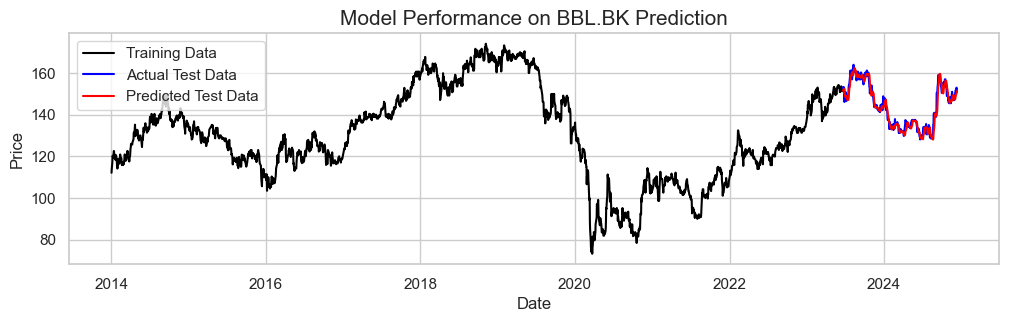

Starting tuning for BDMS.BK...
Best Hyperparameters for BDMS.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0508 - val_loss: 0.1022
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0058 - val_loss: 0.0022
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0044 - val_loss: 0.0713
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0045 - val_loss: 0.0232
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0032 - val_loss: 0.0365
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0029 - val_loss: 0.0335
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0027 - val_loss: 0.0489
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0030 - val_loss: 0.0488
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0024 - val_loss: 0.0405
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0

<Figure size 640x480 with 0 Axes>

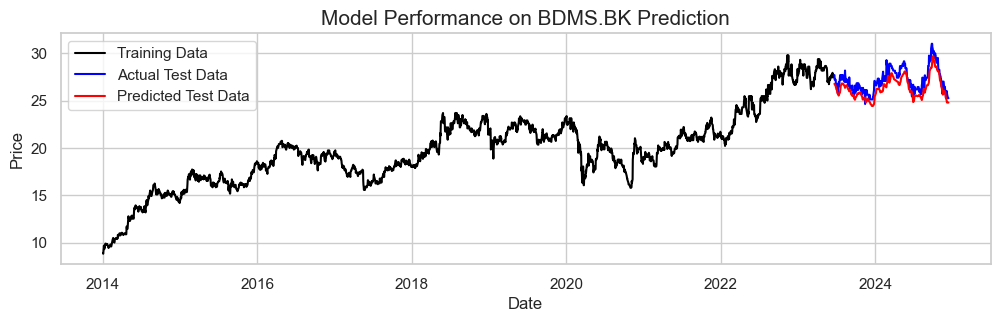

Starting tuning for BH.BK...
Best Hyperparameters for BH.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0414 - val_loss: 0.1046
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0051 - val_loss: 0.0133
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0037 - val_loss: 0.0393
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0035 - val_loss: 0.0105
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 

<Figure size 640x480 with 0 Axes>

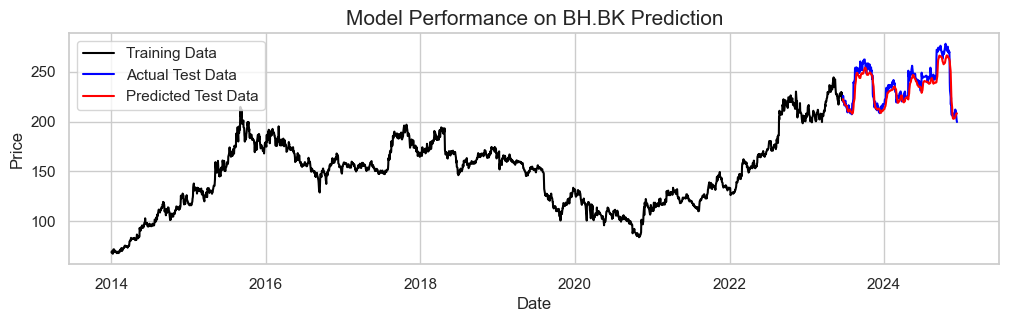

Starting tuning for CPALL.BK...
Best Hyperparameters for CPALL.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0515 - val_loss: 0.0094
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0108 - val_loss: 0.0910
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0136 - val_loss: 0.0548
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0061 - val_loss: 0.0399
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0074 - val_loss: 0.0326
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0043 - val_loss: 0.0209
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0047 - val_loss: 0.0195
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0030 - val_loss: 0.0061
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - lo

<Figure size 640x480 with 0 Axes>

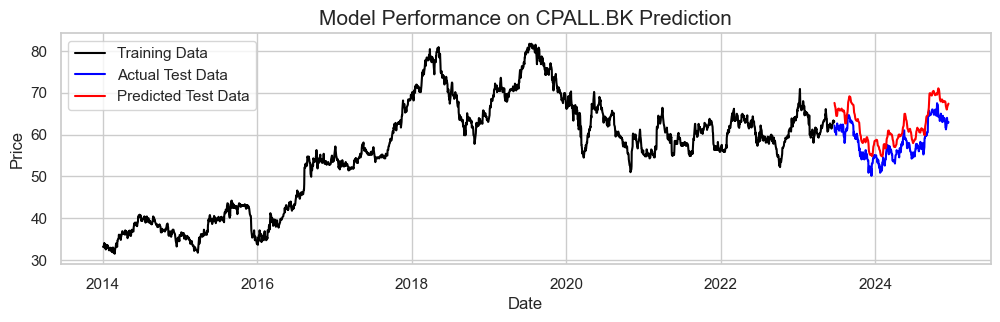

Starting tuning for CPF.BK...
Best Hyperparameters for CPF.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0868 - val_loss: 0.0265
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0126 - val_loss: 0.0043
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0100 - val_loss: 0.0062
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0073 - val_loss: 0.0135
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0050 - val_loss: 0.0207
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0044 - val_loss: 9.3360e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0035 - val_loss: 7.6057e-04
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - l

<Figure size 640x480 with 0 Axes>

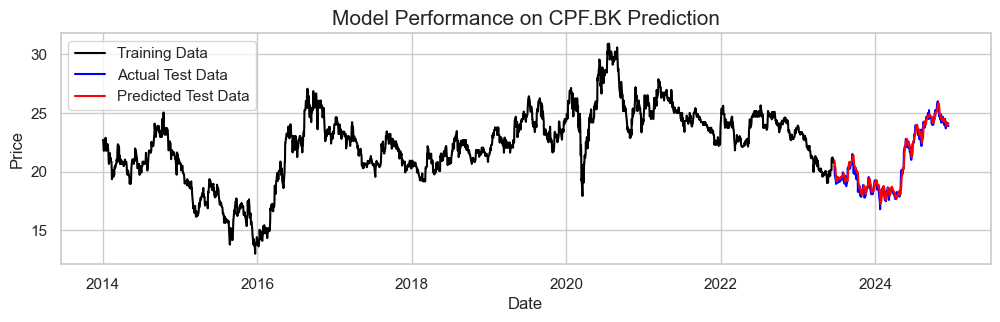

Starting tuning for CPN.BK...
Best Hyperparameters for CPN.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0736 - val_loss: 0.3912
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0385 - val_loss: 0.0220
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0111 - val_loss: 0.0217
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0083 - val_loss: 0.0134
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0076 - val_loss: 0.1240
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0126 - val_loss: 0.0508
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0073 - val_loss: 0.0428
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0071 - val_loss: 0.0743
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0078 - val_loss: 0.0292
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0053 - val_loss: 0.0398
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0057 - val_loss: 0.1097
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.

<Figure size 640x480 with 0 Axes>

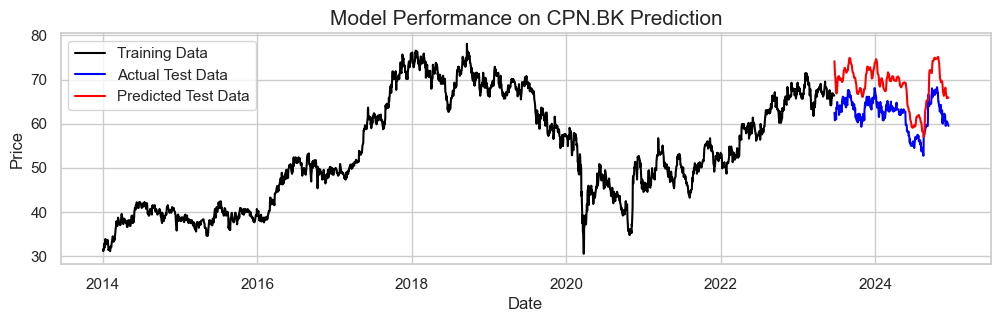

Starting tuning for DELTA.BK...
Best Hyperparameters for DELTA.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0062 - val_loss: 0.0124
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0012 - val_loss: 0.0078
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 9.5941e-04 - val_loss: 0.0097
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 8.6081e-04 - val_loss: 0.0077
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 6.5809e-04 - val_loss: 0.0062
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 6.0098e-04 - val_loss: 0.0069
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 4.4488e-04 - val_loss: 0.0066
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 5.2298e-04 - val_loss: 0.0100
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 5.0892e-04 - val_loss: 0.0072
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 5.7591e-04 - val_loss: 0.0066
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 4.1325e-04 - val_loss: 0.0052
Epoch 12/50
57/57 ━━━━━━━

<Figure size 640x480 with 0 Axes>

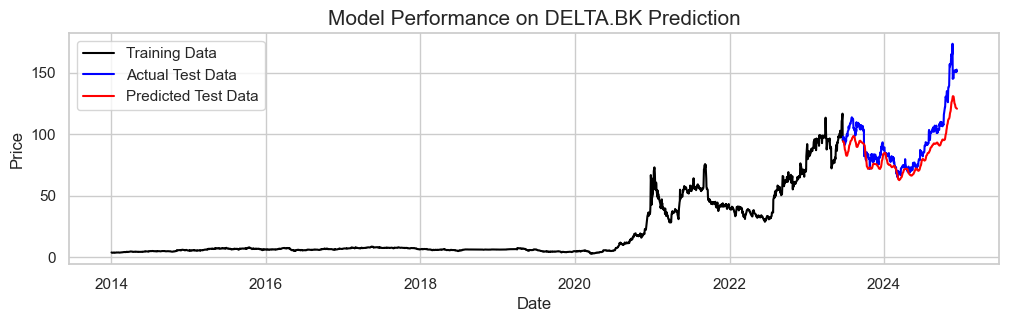

Starting tuning for HMPRO.BK...
Best Hyperparameters for HMPRO.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0563 - val_loss: 0.0484
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0119 - val_loss: 0.1024
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0118 - val_loss: 0.0194
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0060 - val_loss: 0.0413
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0075 - val_loss: 0.0115
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0046 - val_loss: 0.0244
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0049 - val_loss: 0.1050
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0084 - val_loss: 0.1155
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0076 - val_loss: 0.0186
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0035 - val_loss: 0.0266
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss:

<Figure size 640x480 with 0 Axes>

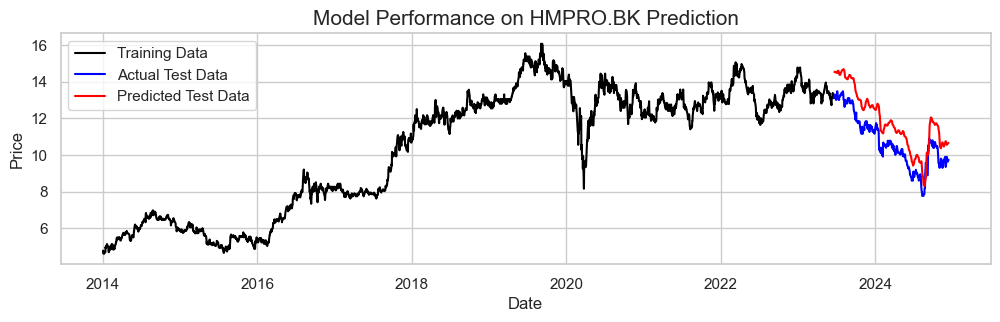

Starting tuning for INTUCH.BK...
Best Hyperparameters for INTUCH.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0032 - val_loss: 0.0078
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0025 - val_loss: 0.0192
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0031 - val_loss: 0.0057
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0018 - val_loss: 0.0121
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - los

<Figure size 640x480 with 0 Axes>

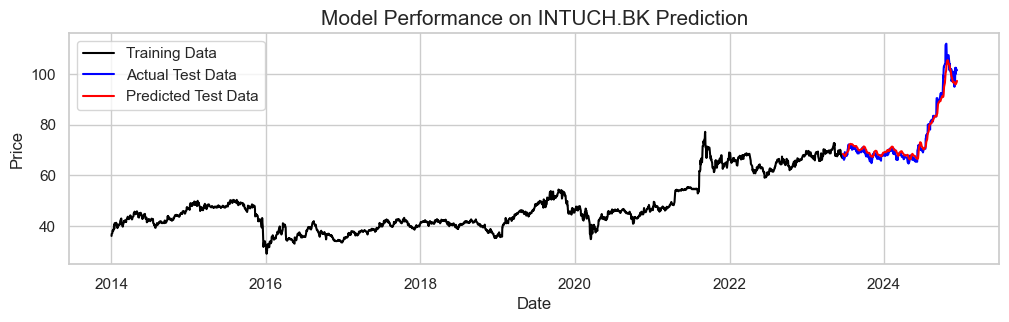

Starting tuning for IVL.BK...
Best Hyperparameters for IVL.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0558 - val_loss: 0.1881
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0157 - val_loss: 0.4553
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0236 - val_loss: 0.2186
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0133 - val_loss: 0.0020
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0057 - val_loss: 0.1803
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0099 - val_loss: 0.0971
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0077 - val_loss: 0.1268
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0072 - val_loss: 0.0892
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0055 - val_loss: 0.1246
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0032 - val_loss: 0.1245
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - lo

<Figure size 640x480 with 0 Axes>

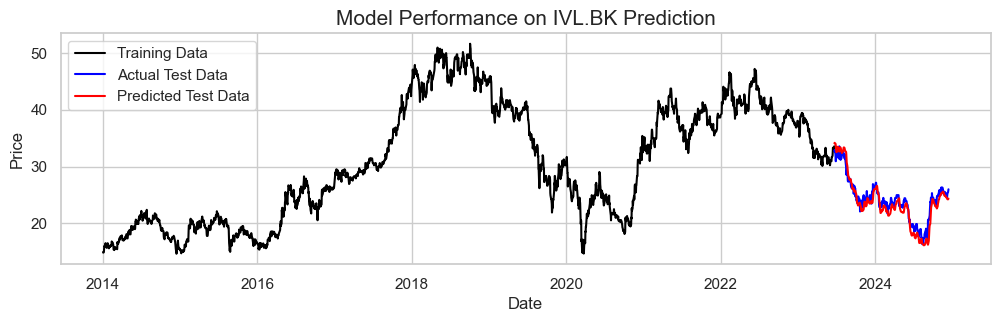

Starting tuning for KBANK.BK...
Best Hyperparameters for KBANK.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0970 - val_loss: 0.0663
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0195 - val_loss: 0.0198
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0122 - val_loss: 0.0136
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0089 - val_loss: 0.0286
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0066 - val_loss: 0.0012
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0061 - val_loss: 0.0388
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0077 - val_loss: 0.0140
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0050 - val_loss: 0.0116
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0052 - val_loss: 0.0135
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0047 - val_loss: 0.0107
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - lo

<Figure size 640x480 with 0 Axes>

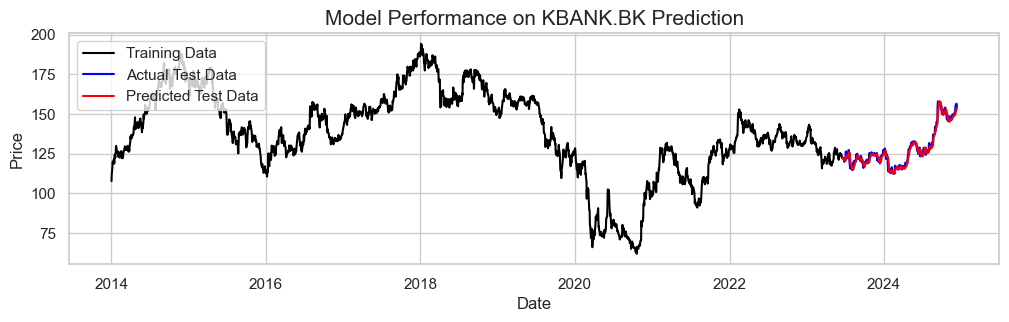

Starting tuning for KTB.BK...
Best Hyperparameters for KTB.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0629 - val_loss: 0.0033
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0087 - val_loss: 0.0114
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0076 - val_loss: 0.0249
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0074 - val_loss: 0.0148
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0041 - val_loss: 0.0123
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0040 - val_loss: 0.0722
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0081 - val_loss: 0.0127
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0035 - val_loss: 0.0141
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - los

<Figure size 640x480 with 0 Axes>

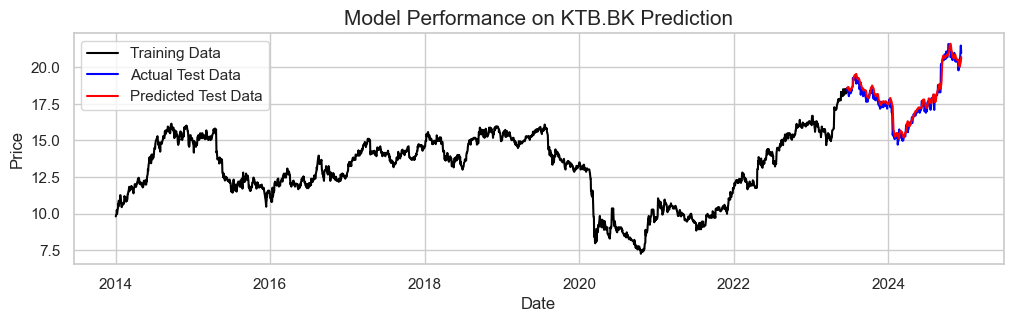

Starting tuning for MINT.BK...
Best Hyperparameters for MINT.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0979 - val_loss: 0.0542
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0171 - val_loss: 0.0488
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0138 - val_loss: 0.0558
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0125 - val_loss: 0.0748
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0130 - val_loss: 0.0880
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0149 - val_loss: 0.0467
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0097 - val_loss: 0.0317
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0080 - val_loss: 0.0024
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0062 - val_loss: 0.0173
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0062 - val_loss: 0.0208
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0054 - val_loss: 0.0515
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - 

<Figure size 640x480 with 0 Axes>

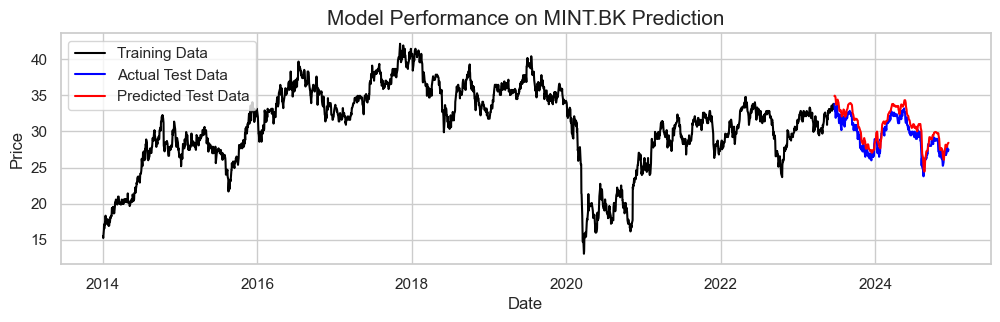

Starting tuning for PTT.BK...
Best Hyperparameters for PTT.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0812 - val_loss: 0.0868
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0190 - val_loss: 0.0396
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0113 - val_loss: 0.0409
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0094 - val_loss: 0.1070
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0114 - val_loss: 0.0622
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0090 - val_loss: 0.0796
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0095 - val_loss: 0.1134
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0109 - val_loss: 0.0458
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0068 - val_loss: 0.0474
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0062 - val_loss: 0.0948
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0087 - val_loss: 0.0537
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 

<Figure size 640x480 with 0 Axes>

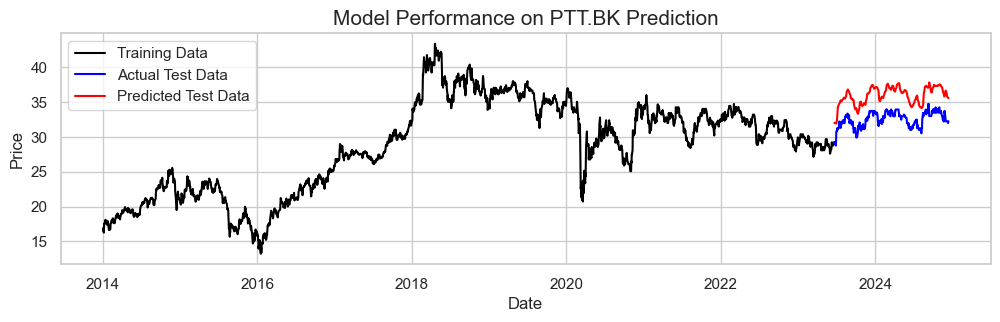

Starting tuning for PTTEP.BK...
Best Hyperparameters for PTTEP.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0327 - val_loss: 0.1218
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0140 - val_loss: 0.0542
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0084 - val_loss: 0.0828
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0085 - val_loss: 0.0415
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0060 - val_loss: 0.0227
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0042 - val_loss: 0.0208
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0039 - val_loss: 0.0187
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0036 - val_loss: 0.0159
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0029 - val_loss: 0.0157
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0028 - val_loss: 0.0383
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0038 - val_loss: 0.0207
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0

<Figure size 640x480 with 0 Axes>

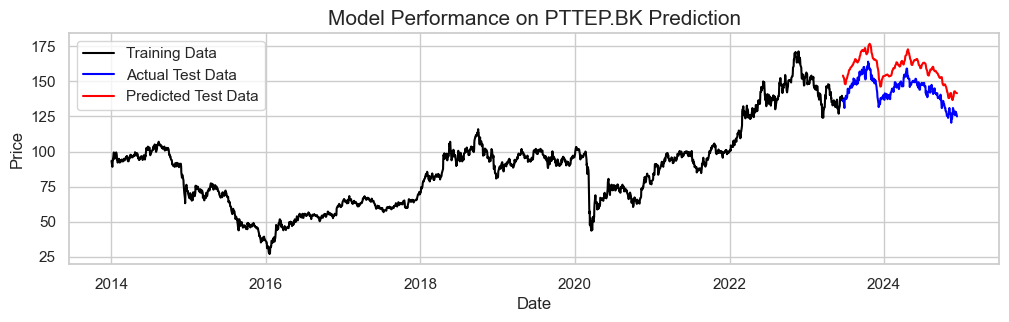

Starting tuning for SCC.BK...
Best Hyperparameters for SCC.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0862 - val_loss: 0.0052
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0136 - val_loss: 0.0121
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0106 - val_loss: 0.0020
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0077 - val_loss: 0.0351
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0094 - val_loss: 0.0014
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0057 - val_loss: 0.0179
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0

<Figure size 640x480 with 0 Axes>

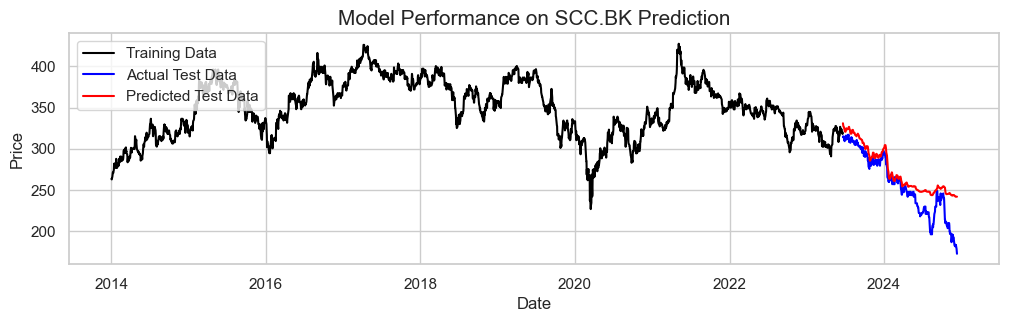

Starting tuning for TRUE.BK...
Best Hyperparameters for TRUE.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0378 - val_loss: 0.0055
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0

<Figure size 640x480 with 0 Axes>

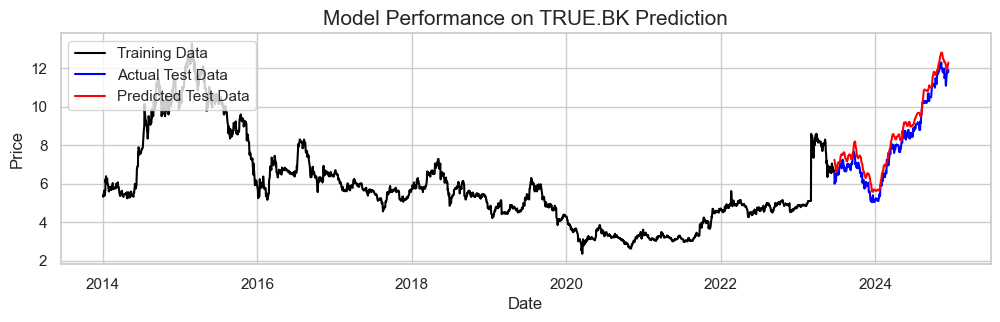

Starting tuning for TTB.BK...
Best Hyperparameters for TTB.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0946 - val_loss: 0.0378
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0152 - val_loss: 0.0354
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0138 - val_loss: 0.0244
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0104 - val_loss: 0.0027
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0058 - val_loss: 0.0104
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0045 - val_loss: 0.0084
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0056 - val_loss: 0.0132
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0

<Figure size 640x480 with 0 Axes>

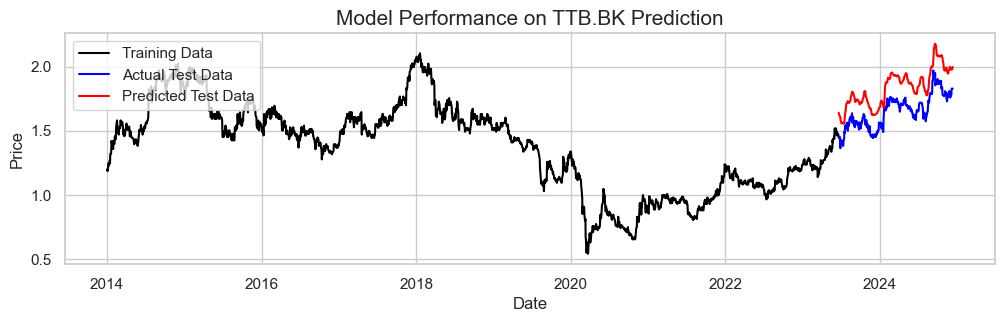

Total time taken for the entire process: 5669.393139839172 seconds


<Figure size 640x480 with 0 Axes>

In [54]:
SET1_results = find_fit_eva(df=set1, test_size=test_size, results=results, tuner=tuner, define_model=define_model)

**Saving Model**

In [230]:
# SET1_results[0] into a single DataFrame
SET1_results_df = pd.concat(
    [df.assign(stock=stock) for stock, df in SET1_results[0].items()],
    ignore_index=True)

# Export
SET1_results_df.to_csv("../Data/SET1_results_df.csv", index=False)

In [228]:
predictions = SET1_results[1]
predictions_df = pd.DataFrame({stock: pred.ravel() for stock, pred in predictions.items()})

# Export
predictions_df.to_csv("../Data/predictions.csv", index=False)

In [117]:
# from tensorflow.keras.models import save_model
# save_model(SET1_results,'../Data/SET1_results.keras')

In [109]:
import os
path = '../Data/SET1_results.keras'
if os.path.exists(path):
    print(f"Model file exists at {path}")
    print(f"File size: {os.path.getsize(path)} bytes")

Model file exists at ../Data/SET1_results.keras
File size: 0 bytes


In [125]:
from tensorflow.keras.models import load_model

try:
    loaded_model = load_model(path)
    print("Model loaded successfully!")
    
    # Optional: Compare model architecture
    print("\nModel Summary:")
    loaded_model.summary()
    
except Exception as e:
    print(f"Error loading model: {e}")

Error loading model: File not found: filepath=../Data/SET1_results.keras. Please ensure the file is an accessible `.keras` zip file.


**Expected Return**

In [236]:
forecasted_returns_pct_list = []
for column in predictions_df.columns:
    # Correctly get the first and last value using .iloc
    forecasted_returns = (predictions_df[column].iloc[-1] - predictions_df[column].iloc[0]) / predictions_df[column].iloc[0]
    forecasted_returns_pct = forecasted_returns * 100
    forecasted_returns_pct_list.append(forecasted_returns_pct)

# Create a DataFrame from the list
forecasted_returns_df = pd.DataFrame(forecasted_returns_pct_list, index=predictions_df.columns, columns=["Expected Return (%)"])

# Find the top 10 highest returns
top_10_returns = forecasted_returns_df.sort_values(by="Expected Return (%)", ascending=False).head(10)
top_10_returns.to_csv("../Data/top_10_returns_SET1.csv", index=False)

**Covariance**